# I. Introduction

![Simulated Annealing](SA_animation.gif)
Simulated annealing is a probablistic technique used for finding an approximate solution to an optimization problem.  In this notebook shows an implementation of [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) to solve the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) between US state capitals.  Briefly, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once.  In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

Image Source: [Simulated Annealing - By Kingpin13 (Own work) [CC0], via Wikimedia Commons (Attribution not required)](https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

In [1]:
import json
import copy

import numpy as np  # contains helpful math functions like numpy.exp()
import numpy.random as random  # see numpy.random module
# import random  # alternative to numpy.random module

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
"""Read input data and define helper functions for visualization."""

# Map services and data available from U.S. Geological Survey, National Geospatial Program.
# Please go to http://www.usgs.gov/visual-id/credit_usgs.html for further information
map = mpimg.imread("map.png")  # US States & Capitals map

# List of 30 US state capitals and corresponding coordinates on the map
with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())


def show_path(path, starting_city, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

('Oklahoma City', [392.8, 356.4])


In [35]:
def simulated_annealing(problem, schedule):
    """
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "successors()" which returns states in the neighborhood of the current
        state, and a callable function "get_value()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class below
        for details.)

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem
    """
    import math
    t = 1
    current = problem
    while True:
        T = schedule(t)
        if T < 1e-10:
            return current
        next = random.choice(current.successors())
        delta_e = next.get_value() - current.get_value()
        if delta_e > 0:
            current = next
        else:
            probability = math.e ** (delta_e / T)
            if random.random() < probability:
                current = next
        t +=1
    

## III. Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid.  The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order.

In [36]:
import math
class TravelingSalesmanProblem:
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.
    
    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))
    
    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    def copy(self):
        """Return a copy of the current board state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.path)
        return coords
    
    def successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)
        """
        successors = []
        n = len(self.path)
        for i in range(n):
            successor = copy.deepcopy(self.path)
            temp = successor[i]
            successor[i] = successor[(i+1) % n]
            successor[(i+1) % n] = temp
            successors.append(TravelingSalesmanProblem(successor))
            
        return successors
            
        

    def get_value(self):
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.
        """
        def distance(x, y):
            x1, y1 = x
            x2, y2 = y
            return math.sqrt((y2 - y1) ** 2 + (x2 -x1) ** 2)
        coords_list = self.coords
        n = len(coords_list)
        return -1 * sum([distance(coords_list[i], coords_list[(i+1) % n]) for i in range(n)])

### Testing TravelingSalesmanProblem
The following tests should validate the class constructor and functionality of the `successors()` and `get_value()` methods.

In [37]:
# Construct an instance of the TravelingSalesmanProblem
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)
assert(tsp.path == test_cities)

In [38]:
# Test the successors() method -- no output means the test passed
successor_paths = [x.path for x in tsp.successors()]
assert(all(x in [[('LA', (0, -4)), ('SF', (0, 0)), ('PHX', (2, -3)), ('DC', (11, 1))],
                 [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('PHX', (2, -3)), ('SF', (0, 0)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3))]]
          for x in successor_paths))

In [39]:
# Test the get_value() method -- no output means the test passed
assert(np.allclose(tsp.get_value(), -28.97, atol=1e-3))

In [40]:
# These are presented as globals so that the signature of schedule()
# matches what is shown in the AIMA textbook; you could alternatively
# define them within the schedule function, use a closure to limit
# their scope, or define an object if you would prefer not to use
# global variables
alpha = 0.95
temperature=1e4

def schedule(time):
    return (alpha ** time) * temperature

### Testing the Temperature Schedule
The following tests should validate the temperature schedule function and perform a simple test of the simulated annealing function to solve a small TSP test case

In [41]:
# test the schedule() function -- no output means that the tests passed
assert(np.allclose(alpha, 0.95, atol=1e-3))
assert(np.allclose(schedule(0), temperature, atol=1e-3))
assert(np.allclose(schedule(10), 5987.3694, atol=1e-3))

In [42]:
# Failure implies that the initial path of the test case has been changed
assert(tsp.path == [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))])
result = simulated_annealing(tsp, schedule)
print("Initial score: {}\nStarting Path: {!s}".format(tsp.get_value(), tsp.path))
print("Final score: {}\nFinal Path: {!s}".format(result.get_value(), result.path))
assert(tsp.path != result.path)
assert(result.get_value() > tsp.get_value())

Initial score: -28.970026243745615
Starting Path: [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
Final score: -27.130286796483155
Final Path: [('LA', (0, -4)), ('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3))]


## V. Run Simulated Annealing on a Larger TSP
Now we are ready to solve a TSP on a bigger problem instance by finding a shortest-path circuit through several of the US state capitals.

Initial path value: 5866.82
[('Oklahoma City', [392.8, 356.4]), ('Montgomery', [559.6, 404.8]), ('Saint Paul', [451.6, 186.0]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Baton Rouge', [489.6, 442.0]), ('Salem', [80.0, 139.2]), ('Little Rock', [469.2, 367.2]), ('Richmond', [673.2, 293.6]), ('Jackson', [501.6, 409.6]), ('Des Moines', [447.6, 246.0]), ('Lansing', [563.6, 216.4]), ('Denver', [293.6, 274.0]), ('Boise', [159.6, 182.8]), ('Raleigh', [662.0, 328.8]), ('Atlanta', [585.6, 376.8])]


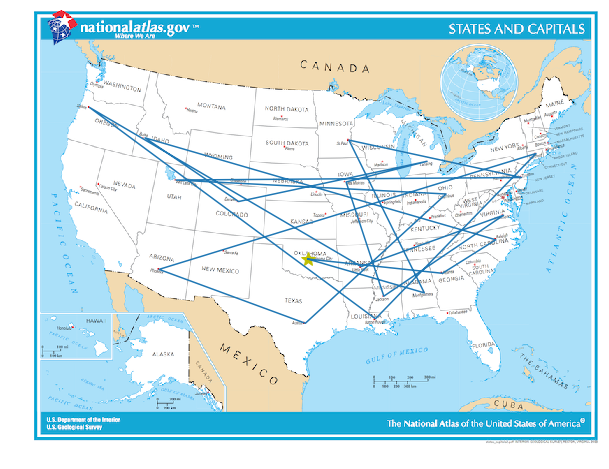

In [43]:
# Create the problem instance and plot the initial state
num_cities = 20
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city)

Final path length: 4018.74
[('Atlanta', [585.6, 376.8]), ('Oklahoma City', [392.8, 356.4]), ('Phoenix', [179.6, 371.2]), ('Denver', [293.6, 274.0]), ('Montgomery', [559.6, 404.8]), ('Hartford', [719.6, 205.2]), ('Columbus', [590.8, 263.2]), ('Baton Rouge', [489.6, 442.0]), ('Austin', [389.2, 448.4]), ('Salem', [80.0, 139.2]), ('Saint Paul', [451.6, 186.0]), ('Des Moines', [447.6, 246.0]), ('Little Rock', [469.2, 367.2]), ('Jackson', [501.6, 409.6]), ('Raleigh', [662.0, 328.8]), ('Richmond', [673.2, 293.6]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Boise', [159.6, 182.8]), ('Lansing', [563.6, 216.4])]


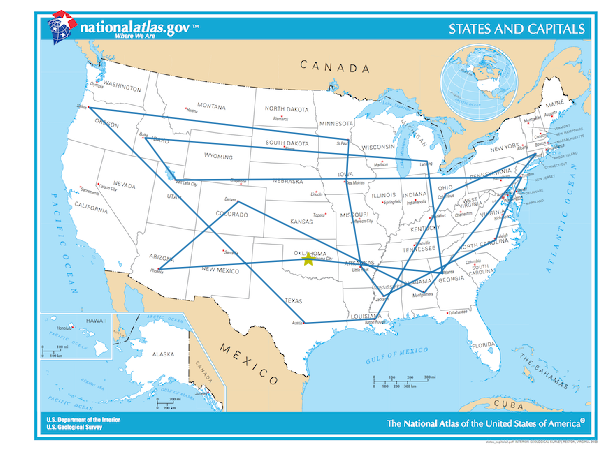

In [45]:
# set the decay rate and initial temperature parameters, then run simulated annealing to solve the TSP
alpha = 0.95
temperature=1e6
result = simulated_annealing(capitals_tsp, schedule)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)